In [50]:
import pandas as pd
import numpy as np

from features import suffix, domains
from rapidfuzz import fuzz
import Levenshtein

# Typosquatting Detection using Levenshtein distance
The idea is to detect phishing by detecting typosquatting - purposefully made typos to imitate popular domains. To detect it Levestein distance will be used - it determines number of single character edits (insertions, deletions, or substitutions) that needs to be done to transform one string into another. 

Intuitively typosquatted URL's will be very close to some popular domains, which will be downloaded and compared

In [10]:
dist = Levenshtein.distance('netflix','netflex')
print(dist)

1


In [11]:
dist = Levenshtein.distance('netflix','google')
print(dist)

6


## Popular domains pre-processing

In [5]:
popular = pd.read_csv('OtherData/cloudflare-radar_top-1000-domains_20260119-20260126.csv')

popular["domains"] = domains(popular["domain"])

print(popular[(popular["domains"].apply(len) > 1)][0:20])

                             domain                          domains
11                         a-mo.net                          {mo, a}
12                     a-msedge.net                      {a, msedge}
19                  ad-delivery.net                   {delivery, ad}
20                     ad-score.com                      {score, ad}
42                  ads-twitter.com                   {ads, twitter}
54                      aiv-cdn.net                       {cdn, aiv}
55                 aiv-delivery.net                  {delivery, aiv}
68             aliexpress-media.com              {aliexpress, media}
78              amazon-adsystem.com               {adsystem, amazon}
89                amp-endpoint2.com                 {endpoint2, amp}
90                amp-endpoint3.com                 {endpoint3, amp}
100  app-analytics-services-att.com  {services, analytics, app, att}
101      app-analytics-services.com       {services, analytics, app}
102             app-measurement.co

In [12]:
def join_domains(row):
    domains_set = row["domains"]
    return "-".join(sorted(list(domains_set)))

popular["joined_domains"] = popular.apply(join_domains, axis = 1)
popular[(popular["domains"].apply(len) > 1) ]


,domain,domains,joined_domains
11,a-mo.net,"{mo, a}",a-mo
12,a-msedge.net,"{a, msedge}",a-msedge
19,ad-delivery.net,"{delivery, ad}",ad-delivery
20,ad-score.com,"{score, ad}",ad-score
42,ads-twitter.com,"{ads, twitter}",ads-twitter
...,...,...,...
921,vscode-cdn.net,"{vscode, cdn}",cdn-vscode
925,wac-msedge.net,"{msedge, wac}",msedge-wac
968,xnxx-cdn.com,"{cdn, xnxx}",cdn-xnxx
970,xvideos-cdn.com,"{cdn, xvideos}",cdn-xvideos


I extracted domains set and then merged each one into single string

## Data pre-processing

In [51]:
data = pd.read_excel('PhishDataset/data_bal - 20000.xlsx')

data["domains"] = domains(data["URLs"])
data["joined_domains"] = data.apply(join_domains, axis = 1)

data.head()


,Labels,URLs,domains,joined_domains
0,1,http://dbs.vote-friend.com/sg?ref=anything,"{friend, vote}",friend-vote
1,0,https://www.reynoldstransfer.com/versa-lift-fo...,{reynoldstransfer},reynoldstransfer
2,1,https://www.halisupportservice.com/Login.php,{halisupportservice},halisupportservice
3,0,https://www.signets.com.br/wp-includes/wlwmani...,{signets},signets
4,1,https://docs.google.com/document/d/e/2PACX-1vT...,{google},google


In [ ]:
def dist(str1, str2):
    return fuzz.ratio(str1, str2) # znormalizowane podobieństwo
    return Levenshtein.distance(str1, str2)

In [64]:
def find_best_match(str1, popular):

    best_dist = 0
    best_match = ""

    for x in popular["joined_domains"]:

        current_dist = dist(str1, x)

        if current_dist > best_dist:
            best_dist = current_dist
            best_match = x
            
    return best_match, best_dist


for x in ["amazen", "gogl", "adidos", "netflex","kotek","aleksandra"]:
    best_match, best_ratio = find_best_match(x, popular)
    print(f"best match for {x} - {best_match} ({best_ratio:.2f})")

best match for amazen - amazon (83.33)
best match for gogl - google (80.00)
best match for adidos - adtidy (66.67)
best match for netflex - netflix (85.71)
best match for kotek - mikrotik (61.54)
best match for aleksandra - pandora (58.82)


In [65]:
def add_best_match(row, popular):
    str1 = row["joined_domains"]
    best_match, best_ratio = find_best_match(str1, popular)
    return best_match, best_ratio

data[["best_match","best_ratio"]] = data.apply(
    lambda row: add_best_match(row, popular),
    axis = 1,
    result_type="expand"
)

In [66]:
data.head()

,Labels,URLs,domains,joined_domains,best_match,best_ratio
0,1,http://dbs.vote-friend.com/sg?ref=anything,"{friend, vote}",friend-vote,freenet,55.555556
1,0,https://www.reynoldstransfer.com/versa-lift-fo...,{reynoldstransfer},reynoldstransfer,centrastage,51.851852
2,1,https://www.halisupportservice.com/Login.php,{halisupportservice},halisupportservice,analytics-app-services,65.000000
3,0,https://www.signets.com.br/wp-includes/wlwmani...,{signets},signets,signal,61.538462
4,1,https://docs.google.com/document/d/e/2PACX-1vT...,{google},google,google,100.000000


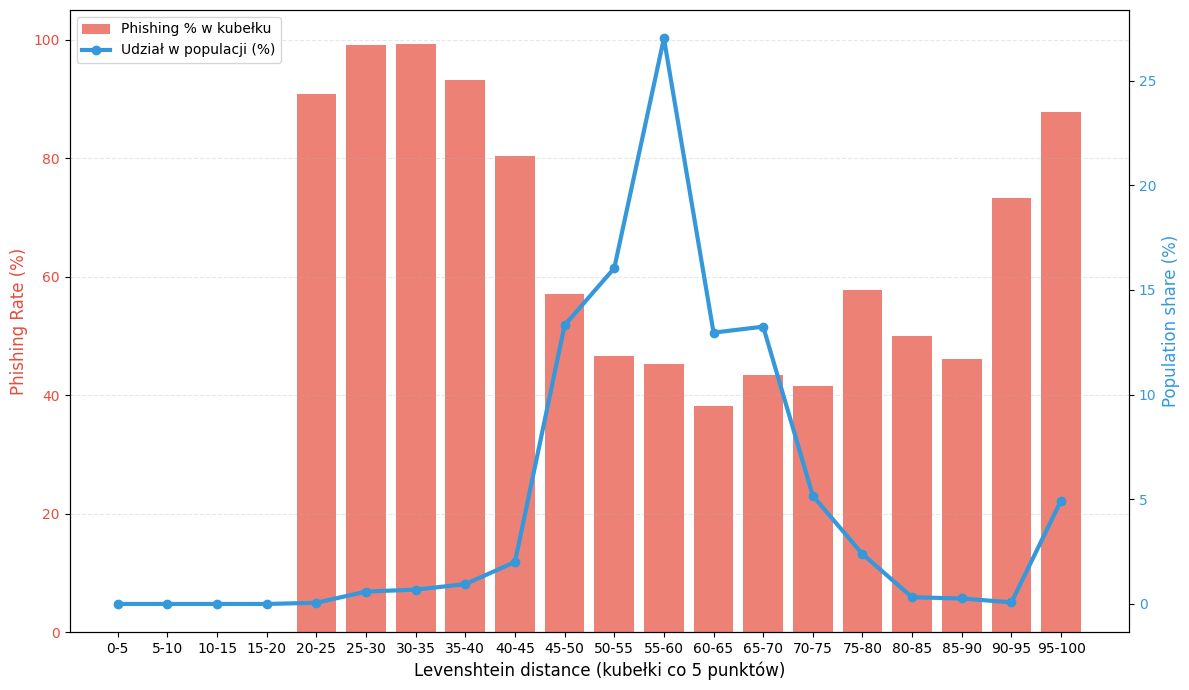

In [67]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

K = 5 

bins = list(range(0, 101, K))

data['ratio_bin'] = pd.cut(data['best_ratio'], bins=bins, include_lowest=True)

stats = data.groupby('ratio_bin', observed=False)['Labels'].agg(['mean', 'count']).reset_index()
stats['phish_rate'] = stats['mean'] * 100
stats['pop_share'] = (stats['count'] / len(data)) * 100

stats['bin_label'] = stats['ratio_bin'].apply(lambda x: f"{int(x.left)}-{int(x.right)}")

fig, ax1 = plt.subplots(figsize=(12, 7))

color_phish = '#e74c3c'
bars = ax1.bar(stats['bin_label'], stats['phish_rate'], color=color_phish, alpha=0.7, label='Phishing % w kubełku')
ax1.set_xlabel(f'Levenshtein distance (kubełki co {K} punktów)', fontsize=12)
ax1.set_ylabel('Phishing Rate (%)', color=color_phish, fontsize=12)
ax1.tick_params(axis='y', labelcolor=color_phish)
ax1.set_ylim(0, 105)

ax2 = ax1.twinx()
color_pop = '#3498db'
line = ax2.plot(stats['bin_label'], stats['pop_share'], color=color_pop, marker='o', linewidth=3, label='Udział w populacji (%)')
ax2.set_ylabel('Population share (%)', color=color_pop, fontsize=12)
ax2.tick_params(axis='y', labelcolor=color_pop)

ax1.grid(axis='y', linestyle='--', alpha=0.3)

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left')

plt.xticks(rotation=45)
plt.tight_layout()